#chest Xray project

##question A1 - binary class

###**A1 - OUR FINAL MODEL**

#### DATA LOADING AND RESIZING

In [ ]:
#DATA LOADING AND RESIZING
from google.colab import drive
import os
import cv2
import numpy as np
from zipfile import ZipFile
from io import BytesIO

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)


# Function to load images from a folder and return X, Y
def load_images_from_folder(folder_path, target_size=(224, 224)):
    X = []  # Images
    y = []  # Labels

    for label in os.listdir(folder_path):
        label_folder = os.path.join(folder_path, label)

        # Ensure it's a directory
        if os.path.isdir(label_folder):
            for filename in os.listdir(label_folder):
                img_path = os.path.join(label_folder, filename)

                # Read the image using OpenCV
                img = cv2.imread(img_path)
                # Resize if needed
                img = cv2.resize(img, target_size)

                subfolder_name = os.path.basename(label_folder)

                # Append image and label to X and y
                X.append(img)
                y.append(subfolder_name)

    return np.array(X), np.array(y)

path_train = '/content/drive/MyDrive/project_ML/all_the_images/train'
X_train, Y_train = load_images_from_folder(path_train)
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)

# Print the unique labels in y_train
unique_labels = np.unique(Y_train)
print("train Unique Labels:", unique_labels)

# print the count of each label
label_counts = {label: np.sum(Y_train == label) for label in unique_labels}
print("train Label Counts:", label_counts)

path_val = '/content/drive/MyDrive/project_ML/all_the_images/val'
X_val, Y_val = load_images_from_folder(path_val)
print("X_val shape:", X_val.shape)
print("Y_val shape:", Y_val.shape)

# Print the unique labels in y_val
val_unique_labels = np.unique(Y_val)
print("val Unique Labels:", val_unique_labels)

# print the count of each label
val_label_counts = {label: np.sum(Y_val == label) for label in val_unique_labels}
print("val Label Counts:", val_label_counts)

Mounted at /content/drive


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/project_ML/all_the_images/train'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#### MODEL - binary class

In [ ]:
# MODEL - binary class #

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
#from tensorflow.keras.optimizers import SGD, Adam
#from tensorflow.keras.utils import to_categorical, plot_model
#from keras.losses import binary_crossentropy


# Enable eager execution
tf.data.experimental.enable_debug_mode()

# Image dimensions of 224x224 with 3 channels
image_height, image_width, num_channels = 224, 224, 3

# Define model
model = Sequential()

# Convolutional layers
model.add(layers.Conv2D(64, (6, 6), strides=(4, 4), activation='relu', padding = 'same', input_shape=(image_height, image_width, num_channels)))

#tf.keras.layers.BatchNormalization(),  # Add batch normalization layer after Conv2D

model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))
model.add(layers.Conv2D(128, (4, 4), activation='relu', padding = 'same'))
model.add(layers.Conv2D(128, (4, 4), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding = 'same'))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
model.add(layers.Conv2D(512, (3, 3), activation='relu', padding = 'same'))
model.add(layers.Conv2D(512, (3, 3), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))

# Flatten layer to convert 3D feature maps to 1D feature vectors
model.add(layers.Flatten())

# Fully connected layers with dropout
model.add(layers.Dense(2048, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification (sigmoid activation)

# Compile the model
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

#### data augmentation and model training

In [ ]:
# data augmentation and model training #

import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras import models
from tensorflow.keras.models import load_model

# Define the directory path
directory_path = '/content/drive/My Drive/models_and_weights/A1/'

# Create the directory if it doesn't exist
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

# Save the model architecture to Google Drive
model.save('/content/drive/My Drive/models_and_weights/A1/model.keras')

# Define the filepath for saving the best weights
checkpoint_filepath_binary = '/content/drive/My Drive/models_and_weights/A1/weights.model.keras'

# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,  # Random rotation up to 20 degrees
    zoom_range=0.15,  # Random zoom
    horizontal_flip=True,  # Random horizontal flip
    vertical_flip=False,    # Random vertical flip
    brightness_range=[0.8, 1.2],  # Random brightness adjustment
    fill_mode='nearest' # Fill mode for augmentation
)

# Fit the data augmentation generator on training data
datagen.fit(X_train)

# Label encoding
label_encoder = LabelEncoder()
Y_train = label_encoder.fit_transform(Y_train)
Y_val = label_encoder.transform(Y_val)

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',   # Monitor validation loss for early stopping
    patience=5,            # Stop training after 5 epochs with no improvement
    restore_best_weights=True,  # Restore weights to the epoch with the best validation performance
    verbose=1             # Print messages indicating early stopping
)

# Define the ModelCheckpoint callback to save the best weights based on validation loss
checkpoint_callback_binary = ModelCheckpoint(
    filepath=checkpoint_filepath_binary,
    monitor='val_loss',  # Monitor validation loss
    save_best_only=True, # Save only the best weights
    mode='min',          # Mode for monitoring the validation metric (minimize validation loss)
    verbose=1            # Print messages indicating when weights are saved
)

# Training the binary classification model using model.fit with data augmentation and early stopping
history_binary = model.fit(
    datagen.flow(X_train, Y_train, batch_size=50),
    epochs=10,
    validation_data=(X_val, Y_val),
    shuffle=True,
    callbacks=[early_stopping, checkpoint_callback_binary]
)

#### Plot Accuracy and Loss

In [ ]:
import matplotlib.pyplot as plt
acc = history_binary.history['accuracy']
val_acc = history_binary.history['val_accuracy']
loss = history_binary.history['loss']
val_loss = history_binary.history['val_loss']
epochs = range(len(acc))
## Plot accuracy
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()
## Plot Loss
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

#### loading data for testing

In [ ]:
#DATA LOADING AND RESIZING
from google.colab import drive
import os
import cv2
import numpy as np
from zipfile import ZipFile
from io import BytesIO

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Function to load images from a folder and return X, y
def load_images_from_folder(folder_path, target_size=(224, 224)):
    X = []  # Images
    y = []  # Labels

    for label in os.listdir(folder_path):
        label_folder = os.path.join(folder_path, label)

        # Ensure it's a directory
        if os.path.isdir(label_folder):
            for filename in os.listdir(label_folder):
                img_path = os.path.join(label_folder, filename)

                # Read the image using OpenCV
                img = cv2.imread(img_path)
                # Resize if needed
                img = cv2.resize(img, target_size)

                subfolder_name = os.path.basename(label_folder)

                # Append image and label to X and y
                X.append(img)
                y.append(subfolder_name)

    return np.array(X), np.array(y)

path_test = '/content/drive/MyDrive/project_ML/all_the_images/test'
X_test, Y_test = load_images_from_folder(path_test)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

# Print the unique labels in y_test
test_unique_labels = np.unique(Y_test)
print("test Unique Labels:", test_unique_labels)

# print the count of each label
test_label_counts = {label: np.sum(Y_test == label) for label in test_unique_labels}
print("test Label Counts:", test_label_counts)

#### confusion matrix

In [ ]:
# confusion matrix #

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder

# Label encoding for testing data
label_encoder = LabelEncoder()
Y_test_encoded = label_encoder.fit_transform(Y_test)

#Predict labels for the test dataset
predicted_labels = (model.predict(X_test) > 0.5).astype("int32")

# Convert true labels to binary format (1 for anomaly, 0 for normal)
binary_true_labels = np.where(Y_test_encoded == 1, 1, 0)

# Compute confusion matrix
conf_matrix = confusion_matrix(Y_test_encoded, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Dataset')
plt.show()

# Calculate evaluation metrics
accuracy = accuracy_score(binary_true_labels, predicted_labels)
precision = precision_score(binary_true_labels, predicted_labels)
recall = recall_score(binary_true_labels, predicted_labels, zero_division=1)  # Set zero_division to 1
f1 = f1_score(binary_true_labels, predicted_labels)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


### ALEXNET (don't check)

In [ ]:
# loading data

from google.colab import drive
import os
import cv2
import numpy as np
from zipfile import ZipFile
from io import BytesIO

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Function to load images from a folder and return X, y
def load_images_from_folder(folder_path, target_size=(224, 224)):
    X = []  # Images
    y = []  # Labels

    for label in os.listdir(folder_path):
        label_folder = os.path.join(folder_path, label)

        # Ensure it's a directory
        if os.path.isdir(label_folder):
            for filename in os.listdir(label_folder):
                img_path = os.path.join(label_folder, filename)

               # Read the image using OpenCV, resize, and convert to grayscale
                img = cv2.imread(img_path)
                img = cv2.resize(img,target_size)

                subfolder_name = os.path.basename(label_folder)

                # Append image and label to X and y
                X.append(img)
                y.append(subfolder_name)

    return np.array(X), np.array(y)

path_train = '/content/drive/MyDrive/project_ML/temp/train'
X_train, Y_train = load_images_from_folder(path_train)
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)

path_val = '/content/drive/MyDrive/project_ML/temp/val'
X_val, Y_val = load_images_from_folder(path_val)
print("X_train shape:", X_val.shape)
print("Y_train shape:", Y_val.shape)

# Print the unique labels in y_train
unique_labels = np.unique(Y_train)
# unique_labels = Y_train.target
print("Unique Labels:", unique_labels)

# Optionally, print the count of each label
label_counts = {label: np.sum(Y_train == label) for label in unique_labels}
print("Label Counts:", label_counts)

In [ ]:
# alexnet

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

# Create a Sequential model
model = Sequential()

# First convolutional layer
model.add(Conv2D(96, (11, 11), strides=(4, 4), activation='relu', padding='valid', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((3, 3), strides=(2, 2)))

# Second convolutional layer
model.add(Conv2D(256, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D((3, 3), strides=(2, 2)))

# Third convolutional layer
model.add(Conv2D(384, (3, 3), activation='relu', padding='same'))

# Fourth convolutional layer
model.add(Conv2D(384, (3, 3), activation='relu', padding='same'))

# Fifth convolutional layer
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((3, 3), strides=(2, 2)))

# Flatten layer
model.add(Flatten())

# Fully connected layers with dropout
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification (sigmoid activation)

# Compile the model
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

In [ ]:
# data augmentation and model training
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,  # Random rotation up to 20 degrees
    width_shift_range=0.2,  # Random horizontal shift
    height_shift_range=0.2,  # Random vertical shift
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Random horizontal flip
    vertical_flip=False,    # Random vertical flip
)

# Fit the data augmentation generator on your training data
datagen.fit(X_train)

# Label encoding
label_encoder = LabelEncoder()
Y_train = label_encoder.fit_transform(Y_train)
Y_val = label_encoder.transform(Y_val)

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',   # Monitor validation loss for early stopping
    patience=5,            # Stop training after 5 epochs with no improvement
    restore_best_weights=True,  # Restore weights to the epoch with the best validation performance
    verbose=1             # Print messages indicating early stopping
)

# Training the model using model.fit with data augmentation
history = model.fit(
    datagen.flow(X_train, Y_train, batch_size=64),
    epochs=10,
    validation_data=(X_val, Y_val),
    shuffle=True,
    callbacks=[early_stopping]
)


###VGG (don't check)

In [ ]:
# loading data for VGG

from google.colab import drive
import os
import cv2
import numpy as np
from zipfile import ZipFile
from io import BytesIO

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)


# Path to the zip file in Google Drive
zip_file_path = '/content/drive/MyDrive/project_ML/archive.zip'

# Extracted folder path
extracted_folder = '/content/extracted_folder'

# Function to load images from a folder and return X, y
def load_images_from_folder(folder_path, target_size=(224, 224)):
    X = []  # Images
    y = []  # Labels

    for label in os.listdir(folder_path):
        label_folder = os.path.join(folder_path, label)

        # Ensure it's a directory
        if os.path.isdir(label_folder):
            for filename in os.listdir(label_folder):
                img_path = os.path.join(label_folder, filename)

               # Read the image using OpenCV, resize,

                img = cv2.imread(img_path)
                img = cv2.resize(img,target_size)

                subfolder_name = os.path.basename(label_folder)

                # Append image and label to X and y
                X.append(img)
                y.append(subfolder_name)

    return np.array(X), np.array(y)

path_train = '/content/drive/MyDrive/project_ML/temp/train'
X_train, Y_train = load_images_from_folder(path_train)
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)

path_val = '/content/drive/MyDrive/project_ML/temp/val'
X_val, Y_val = load_images_from_folder(path_val)
print("X_train shape:", X_val.shape)
print("Y_train shape:", Y_val.shape)

# Print the unique labels in y_train
unique_labels = np.unique(Y_train)
# unique_labels = Y_train.target
print("Unique Labels:", unique_labels)

# Optionally, print the count of each label
label_counts = {label: np.sum(Y_train == label) for label in unique_labels}
print("Label Counts:", label_counts)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

# Define input shape
input_shape = (224, 224, 3)

# Define input tensor
inputs = Input(shape=input_shape)

# Define convolutional layers
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D((2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool2 = MaxPooling2D((2, 2))(conv4)

conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
pool3 = MaxPooling2D((2, 2))(conv7)

conv8 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
conv9 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv8)
conv10 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv9)
pool4 = MaxPooling2D((2, 2))(conv10)

conv11 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv12 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv11)
conv13 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv12)
pool5 = MaxPooling2D((2, 2))(conv13)

# Flatten layer to convert 3D feature maps to 1D feature vectors
flatten = Flatten()(pool5)

# Fully connected layers with dropout
dense1 = Dense(256, activation='relu')(flatten)
dropout1 = Dropout(0.3)(dense1)

dense2 = Dense(256, activation='relu')(dropout1)
dropout2 = Dropout(0.3)(dense2)

# Output layer
outputs = Dense(1, activation='sigmoid')(dropout2)

# Create the model
vgg_model = Model(inputs=inputs, outputs=outputs)

# Compile the model
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
vgg_model.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Display the summary to check the architecture
vgg_model.summary()


In [ ]:
# VGG MODEL -------------------
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.models import Model

# Assuming image dimensions of 224x224 with 3 channels (GreyScasle with the dup channels -- RGB)
image_height, image_width, num_channels = 224, 224, 3

# Define input tensor with the correct shape for images with 3 channels
input_tensor = Input(shape=(image_height, image_width, num_channels))

# Load VGG19 model with pretrained weights, specifying input tensor
vgg_base = VGG19(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Freeze convolutional layers
for layer in vgg_base.layers:
    layer.trainable = False

# Add custom fully connected layers for fine-tuning
flatten_layer = Flatten()(vgg_base.output)

# Fully connected layers with dropout
dense_layer1 = Dense(256, activation='relu')(flatten_layer)
dropout_layer1 = Dropout(0.3)(dense_layer1)
dense_layer2 = Dense(256, activation='relu')(dropout_layer1)
dropout_layer2 = Dropout(0.3)(dense_layer2)
output_layer = Dense(1, activation='sigmoid')(dropout_layer2)  # Binary classification (sigmoid activation)

# Create the fine-tuned model
fine_tuned_model = Model(inputs=vgg_base.input, outputs=output_layer)

# Compile the model
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # Adjust the learning rate as needed
fine_tuned_model.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Display the summary to check the architecture
fine_tuned_model.summary()

In [ ]:
# VGG - data augmentation and model training
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,  # Random rotation up to 20 degrees
    width_shift_range=0.2,  # Random horizontal shift
    height_shift_range=0.2,  # Random vertical shift
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Random horizontal flip
    vertical_flip=False,    # Random vertical flip
)

# Fit the data augmentation generator on your training data
datagen.fit(X_train)

# Label encoding
label_encoder = LabelEncoder()
Y_train = label_encoder.fit_transform(Y_train)
Y_val = label_encoder.transform(Y_val)

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',   # Monitor validation loss for early stopping
    patience=5,            # Stop training after 5 epochs with no improvement
    restore_best_weights=True,  # Restore weights to the epoch with the best validation performance
    verbose=1             # Print messages indicating early stopping
)

# Training the model using model.fit with data augmentation
history = vgg_model.fit(
    datagen.flow(X_train, Y_train, batch_size=64),
    epochs=8,
    validation_data=(X_val, Y_val),
    shuffle=True,
    callbacks=[early_stopping]
)

##question A2 -multi class


###**A2 - OUR FINAL MODEL**

#### DATA LOADING AND RESIZING

In [ ]:
# DATA LOADING AND RESIZING #

from google.colab import drive
import os
import cv2
import numpy as np
from zipfile import ZipFile
from io import BytesIO

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Function to load images from a folder and return X, Y
def load_images_from_folder(folder_path):
    X = []  # Images
    y = []  # Labels

    for label in os.listdir(folder_path):
        label_folder = os.path.join(folder_path, label)

        # Ensure it's a directory
        if os.path.isdir(label_folder):
            for filename in os.listdir(label_folder):
                img_path = os.path.join(label_folder, filename)

                # Read the image using OpenCV
                img = cv2.imread(img_path)

                # Resize if needed
                img = cv2.resize(img, (224, 224))

                if "bacteria" in filename:
                  y.append("bacteria")
                elif "virus" in filename:
                  y.append("virus")
                else:
                  y.append("normal")

                # Append image and label to X and y
                X.append(img)


    return np.array(X), np.array(y)



path_train = '/content/drive/MyDrive/project_ML/all_the_images/train'
X_train, Y_train = load_images_from_folder(path_train)
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)

# Print the unique labels in y_train
unique_labels = np.unique(Y_train)
print("train Unique Labels:", unique_labels)

# print the count of each label
label_counts = {label: np.sum(Y_train == label) for label in unique_labels}
print("train Label Counts:", label_counts)

path_val = '/content/drive/MyDrive/project_ML/all_the_images/val'
X_val, Y_val = load_images_from_folder(path_val)
print("X_val shape:", X_val.shape)
print("Y_val shape:", Y_val.shape)

# Print the unique labels in y_val
val_unique_labels = np.unique(Y_val)
print("val Unique Labels:", val_unique_labels)

# print the count of each label
val_label_counts = {label: np.sum(Y_val == label) for label in val_unique_labels}
print("val Label Counts:", val_label_counts)

#### MODEL - multiclass

In [ ]:
# MODEL - multiclass #

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
#from tensorflow.keras.optimizers import Adam

# Enable eager execution
tf.data.experimental.enable_debug_mode()

# Image dimensions of 224x224 with 3 channels
image_height, image_width, num_channels = 224, 224, 3

# Define model
model = Sequential()

# Convolutional layers
model.add(layers.Conv2D(64, (6, 6), strides=(4, 4), activation='relu', padding = 'same', input_shape=(image_height, image_width, num_channels)))

model.add(layers.BatchNormalization()) # Add batch normalization layer after Conv2D

model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))
model.add(layers.Conv2D(64, (4, 4), activation='relu', padding = 'same'))
model.add(layers.Conv2D(64, (4, 4), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding = 'same'))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding = 'same'))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding = 'same'))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))

# Flatten layer to convert 3D feature maps to 1D feature vectors
model.add(layers.Flatten())

# Fully connected layers with dropout
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(3, activation='softmax'))  # multi classification
#kernel_regularizer=regularizers.l2(0.001)

# Compile the model
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

#### data augmentation and model training

In [ ]:
# data augmentation and model training #

import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models
from tensorflow.keras.models import load_model


# Define the directory path
directory_path = '/content/drive/My Drive/models_and_weights/A2/'

# Create the directory if it doesn't exist
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

# Save the model architecture to Google Drive
model.save('/content/drive/My Drive/models_and_weights/A2/model.keras')

# Define the filepath for saving the best weights
checkpoint_filepath_multiclass = '/content/drive/My Drive/models_and_weights/A2/weights.model.keras'

# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,  # Random rotation up to 20 degrees
    zoom_range=0.15,  # Random zoom
    horizontal_flip=True,  # Random horizontal flip
    vertical_flip=False,    # Random vertical flip
    brightness_range=[0.8, 1.2],  # Random brightness adjustment
    fill_mode='nearest' # Fill mode for augmentation
)

# Fit the data augmentation generator on your training data
datagen.fit(X_train)

# Label encoding
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_val_encoded = label_encoder.transform(Y_val)

# Convert class labels to one-hot encoding
Y_train_one_hot = to_categorical(Y_train_encoded, num_classes=3)
Y_val_one_hot = to_categorical(Y_val_encoded, num_classes=3)

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',   # Monitor validation loss for early stopping
    patience=5,            # Stop training after 5 epochs with no improvement
    restore_best_weights=True,  # Restore weights to the epoch with the best validation performance
    verbose=1             # Print messages indicating early stopping
)

# Define the ModelCheckpoint callback to save the best weights based on validation loss
checkpoint_callback_multiclass = ModelCheckpoint(
    filepath=checkpoint_filepath_multiclass,
    monitor='val_loss',  # Monitor validation loss
    save_best_only=True, # Save only the best weights
    mode='min',          # Mode for monitoring the validation metric (minimize validation loss)
    verbose=1            # Print messages indicating when weights are saved
)

# Training the multiclass classification model using model.fit with data augmentation and early stopping
history_multiclass = model.fit(
    datagen.flow(X_train, Y_train_one_hot, batch_size=25),
    epochs=16,
    validation_data=(X_val, Y_val_one_hot),
    shuffle=True,
    callbacks=[early_stopping, checkpoint_callback_multiclass]
)

#### Plot Accuracy and Loss:

In [ ]:
import matplotlib.pyplot as plt
acc = history_multiclass.history['accuracy']
val_acc = history_multiclass.history['val_accuracy']
loss = history_multiclass.history['loss']
val_loss = history_multiclass.history['val_loss']
epochs = range(len(acc))
## Plot accuracy
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()
## Plot Loss
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

#### loading data for testing

In [ ]:
from google.colab import drive
import os
import cv2
import numpy as np
from zipfile import ZipFile
from io import BytesIO

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Function to load images from a folder and return X, Y
def load_images_from_folder(folder_path):
    X = []  # Images
    y = []  # Labels

    for label in os.listdir(folder_path):
        label_folder = os.path.join(folder_path, label)

        # Ensure it's a directory
        if os.path.isdir(label_folder):
            for filename in os.listdir(label_folder):
                img_path = os.path.join(label_folder, filename)

                # Read the image using OpenCV
                img = cv2.imread(img_path)

                # Resize if needed
                img = cv2.resize(img, (224, 224))

                if "bacteria" in filename:
                  y.append("bacteria")
                elif "virus" in filename:
                  y.append("virus")
                else:
                  y.append("normal")

                # Append image and label to X and y
                X.append(img)


    return np.array(X), np.array(y)


#path_test = '/content/drive/MyDrive/project_ML/temp/test'
path_test = '/content/drive/MyDrive/project_ML/all_the_images/test'
X_test, Y_test = load_images_from_folder(path_test)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

# Print the unique labels in y_test
test_unique_labels = np.unique(Y_test)
print("test Unique Labels:", test_unique_labels)

# print the count of each label
test_label_counts = {label: np.sum(Y_test == label) for label in test_unique_labels}
print("test Label Counts:", test_label_counts)

#### confusion matrix

In [ ]:
# confusion matrix #

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Label encoding for testing data
label_encoder = LabelEncoder()
Y_test_encoded = label_encoder.fit_transform(Y_test)

# Define the class labels
class_labels = ['Bacteria', 'Normal', 'Virus']

# Predict labels for the test dataset
predicted_labels = np.argmax(model.predict(X_test), axis=1)  # selects the class with the highest probability

# Compute confusion matrix
conf_matrix = confusion_matrix(Y_test_encoded, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Dataset')
plt.show()

# Generate classification report
report = classification_report(Y_test_encoded, predicted_labels, target_names=class_labels)
print("Classification Report:")
print(report)

# Calculate evaluation metrics
accuracy = accuracy_score(Y_test_encoded, predicted_labels)
precision = precision_score(Y_test_encoded, predicted_labels, average='weighted')
recall = recall_score(Y_test_encoded, predicted_labels, average='weighted')
f1 = f1_score(Y_test_encoded, predicted_labels, average='weighted')

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

###A2 - based on alexnet (don't check)

In [ ]:
from google.colab import drive
import os
import cv2
import numpy as np
from zipfile import ZipFile
from io import BytesIO

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Function to load images from a folder and return X, Y
def load_images_from_folder(folder_path):
    X = []  # Images
    y = []  # Labels

    for label in os.listdir(folder_path):
        label_folder = os.path.join(folder_path, label)

        # Ensure it's a directory
        if os.path.isdir(label_folder):
            for filename in os.listdir(label_folder):
                img_path = os.path.join(label_folder, filename)

                # Read the image using OpenCV
                img = cv2.imread(img_path)

                # Resize if needed
                img = cv2.resize(img, (224, 224))

                if "bacteria" in filename:
                  y.append("bacteria")
                elif "virus" in filename:
                  y.append("virus")
                else:
                  y.append("normal")

                # Append image and label to X and y
                X.append(img)


    return np.array(X), np.array(y)

path_train = '/content/drive/MyDrive/project_ML/temp/train'
X_train, Y_train = load_images_from_folder(path_train)
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)

path_val = '/content/drive/MyDrive/project_ML/temp/val'
X_val, Y_val = load_images_from_folder(path_val)
print("X_train shape:", X_val.shape)
print("Y_train shape:", Y_val.shape)

# Print the unique labels in y_train
unique_labels = np.unique(Y_train)
# unique_labels = Y_train.target
print("Unique Labels:", unique_labels)

# Optionally, print the count of each label
label_counts = {label: np.sum(Y_train == label) for label in unique_labels}
print("Label Counts:", label_counts)

In [ ]:

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical, plot_model

# Enable eager execution
tf.data.experimental.enable_debug_mode()

# Assuming image dimensions of 224x224 with 3 channels (RGB)
image_height, image_width, num_channels = 224, 224, 3

# Define AlexNet model
model = Sequential()

# Convolutional layers
model.add(layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(image_height, image_width, num_channels)))
model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))
model.add(layers.Conv2D(256, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))
model.add(layers.Conv2D(384, (3, 3), activation='relu'))
model.add(layers.Conv2D(384, (3, 3), activation='relu'))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))

# Flatten layer to convert 3D feature maps to 1D feature vectors
model.add(layers.Flatten())

# Fully connected layers with dropout
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))  # Multi classification (softmax activation)

# Compile the model
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # Adjust the learning rate as needed
model.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# Use LabelEncoder to encode string labels to integers
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_val_encoded = label_encoder.transform(Y_val)

# Convert class labels to one-hot encoding
Y_train_one_hot = to_categorical(Y_train_encoded, num_classes=3)
Y_val_one_hot = to_categorical(Y_val_encoded, num_classes=3)

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Train the model with early stopping
model.fit(X_train, Y_train_one_hot, batch_size=50, epochs=10, validation_data=(X_val, Y_val_one_hot), callbacks=[early_stopping])


## question B

### classifying new image using binary model


####Classify the new image using kNN

In [ ]:
from tensorflow.keras.optimizers import Adam
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras import models
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import cv2
import joblib


# Create the embedding model right before the fully connected layers
embedding_model = models.Model(inputs=model.input, outputs=model.layers[-4].output)

# Use the embedding_model to get the embedding vectors directly
embedding_vectors_train = embedding_model.predict(X_train)

# Load the new image
# new_image = "/content/drive/MyDrive/project_ML/temp/test/PNEUMONIA/person1_virus_6.jpeg"
#new_image = "/content/drive/MyDrive/project_ML/temp/test/PNEUMONIA/person3_bacteria_12.jpeg"
#new_image = "/content/drive/MyDrive/project_ML/temp/test/NORMAL/NORMAL2-IM-0381-0001.jpeg"
new_image = "/content/drive/MyDrive/project_ML/all_the_images/test/PNEUMONIA/person1685_virus_2903.jpeg"

# Read the image using OpenCV
img = cv2.imread(new_image)

img = cv2.resize(img, (224, 224))

# Get the embedding for the new image
new_image_embedding = embedding_model.predict(tf.expand_dims(img, axis=0))

# Apply kNN on embeddings
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(embedding_vectors_train, Y_train)

# Define the directory path
directory_path = '/content/drive/My Drive/models_and_weights/B/binary/'

# Create the directory if it doesn't exist
os.makedirs(directory_path, exist_ok=True)

# Save the trained classifier to Google Drive
joblib.dump(knn_classifier, os.path.join(directory_path, 'knn_classifier.pkl'))

# Classify the new image using kNN on new image embedding vector
predicted_class = knn_classifier.predict(new_image_embedding)

decoded_label = label_encoder.inverse_transform(predicted_class)[0]
print(f"Predicted Class: {decoded_label}")

# Display the image using OpenCV
cv2_imshow(cv2.imread(new_image))

####Visualize the t-SNE embeddings for the training set

In [ ]:
# Apply t-SNE on embeddings
tsne = TSNE(n_components=2, random_state=42)
embedding_tsne = tsne.fit_transform(embedding_vectors_train) # Visualizing Embedding Vectors

# Visualize the t-SNE embeddings for the training set
plt.scatter(embedding_tsne[:, 0], embedding_tsne[:, 1], c=Y_train, cmap='viridis')
plt.title('t-SNE Visualization of Embeddings (Training Set)')
plt.show()

### classifying new image using multi class model


####Classify the new image using kNN

In [ ]:
from tensorflow.keras.optimizers import Adam
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras import models
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import cv2
import joblib

# Create the embedding model right before the fully connected layers
embedding_model = models.Model(inputs=model.input, outputs=model.layers[-4].output)

# Use the embedding_model to get the embedding vectors directly
embedding_vectors_train = embedding_model.predict(X_train)

# Load the new image
# new_image = "/content/drive/MyDrive/project_ML/temp/test/PNEUMONIA/person1_virus_6.jpeg"
# new_image = "/content/drive/MyDrive/project_ML/temp/test/PNEUMONIA/person3_bacteria_12.jpeg"
# new_image = "/content/drive/MyDrive/project_ML/temp/test/NORMAL/Copy of Copy of IM-0001-0001.jpeg"
new_image = "/content/drive/MyDrive/project_ML/all_the_images/test/NORMAL/IM-0001-0001.jpeg"

# Read the image using OpenCV
img = cv2.imread(new_image)

# Resize if needed
img = cv2.resize(img, (224, 224))

# Get the embedding for the new image
new_image_embedding = embedding_model.predict(tf.expand_dims(img, axis=0))

# Apply kNN on embeddings
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(embedding_vectors_train, Y_train)

# Define the directory path
directory_path = '/content/drive/My Drive/models_and_weights/B/multiclass/'

# Create the directory if it doesn't exist
os.makedirs(directory_path, exist_ok=True)

# Save the trained classifier to Google Drive
joblib.dump(knn_classifier, os.path.join(directory_path, 'knn_classifier.pkl'))

# Classify the new image using kNN on new image embedding vector
predicted_class = knn_classifier.predict(new_image_embedding)
print(f"Predicted Class: {predicted_class}")

# Display the image using OpenCV
img = cv2.imread(new_image)
resized_img = cv2.resize(img, (400, 400), interpolation=cv2.INTER_AREA)
cv2_imshow(resized_img)

####Visualize the t-SNE embeddings for the training set

In [ ]:
import pandas as pd

# Apply t-SNE on embeddings
tsne = TSNE(n_components=2, random_state=42)
embedding_tsne = tsne.fit_transform(embedding_vectors_train)

# Visualize the t-SNE embeddings for the training set
plt.scatter(embedding_tsne[:, 0], embedding_tsne[:, 1], c=Y_train_encoded, cmap='viridis')
plt.title('t-SNE Visualization of Embeddings (Training Set)')
plt.show()

## question D - anomaly detection

### **OUR FINAL MODEL**

#### DATA LOADING AND RESIZING

In [ ]:
# DATA LOADING AND RESIZING #

from google.colab import drive
import os
import cv2
import numpy as np
from zipfile import ZipFile
from io import BytesIO

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Function to load images from a folder and return X, Y
def load_images_from_folder(folder_path, image_size=(224, 224)):
    X = []  # Images

    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)

        # Read the image using OpenCV
        img = cv2.imread(img_path)

        # Resize if needed
        img = cv2.resize(img, image_size)

        # Convert pixel values to floating point numbers
        img_float = img.astype('float32')

        # Normalize pixel values to [0, 1]
        img_normalized = img_float / 255.0

        # Append image
        X.append(img_normalized)

    return np.array(X)

path_train = '/content/drive/MyDrive/project_ML/all_the_images/train/NORMAL'
X_train = load_images_from_folder(path_train)
print("X_train shape:", X_train.shape)

path_val = '/content/drive/MyDrive/project_ML/all_the_images/val/NORMAL'
X_val = load_images_from_folder(path_val)
print("X_val shape:", X_val.shape)

#### MODEL

In [ ]:
# MODEL - autoencoder #

import tensorflow as tf
from tensorflow.keras import layers, models

latent_dim = 64

# Encoder
encoder_input = layers.Input(shape=(224,224,3))

x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoder_input)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
latent_space = layers.MaxPooling2D((2, 2), padding='same')(x)

encoder = models.Model(encoder_input, latent_space, name='encoder')
encoder.summary()

# Decoder
decoder_input = layers.Input(shape=latent_space.shape[1:])
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(decoder_input)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoder_output = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

decoder = models.Model(decoder_input, decoder_output, name='decoder')
decoder.summary()

# Autoencoder = Encoder + Decoder
autoencoder_input = layers.Input(shape=(224,224,3))
latent_space = encoder(autoencoder_input)
autoencoder_output = decoder(latent_space)

autoencoder = models.Model(autoencoder_input, autoencoder_output, name='autoencoder')
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
#autoencoder.compile(optimizer=custom_optimizer, loss='mean_absolute_error', metrics=['mae'])
#autoencoder.compile(optimizer=custom_optimizer, loss='mean_squared_error', metrics=['mse'])
autoencoder.compile(optimizer=custom_optimizer, loss='binary_crossentropy')
autoencoder.summary()

#### TRAINING

In [ ]:
# TRAINING #

import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the directory path
directory_path = '/content/drive/My Drive/models_and_weights/D/'

# Create the directory if it doesn't exist
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

# Save the model architecture to Google Drive
autoencoder.save('/content/drive/My Drive/models_and_weights/D/model.keras')

# Define the filepath for saving the best weights
checkpoint_filepath_anomaly = '/content/drive/My Drive/models_and_weights/D/weights.model.keras'

# Define the callback to save the best weights
checkpoint_callback_anomaly = ModelCheckpoint(
    filepath=checkpoint_filepath_anomaly,
    save_weights_only=True,
    monitor='val_loss',  # Monitor validation loss
    mode='min',          # Minimize validation loss
    save_best_only=True,  # Save only the best weights
    verbose=1            # Print messages indicating when weights are saved
)

# Train the anomaly detection model with the callback
history_anomaly = autoencoder.fit(
    X_train, X_train,
    epochs=10,
    batch_size=50,
    shuffle=True,
    validation_data=(X_val, X_val),
    callbacks=[checkpoint_callback_anomaly]
)

#### Plot Accuracy and Loss

In [ ]:
import matplotlib.pyplot as plt

# Check if acc is not None
if acc is not None:
    epochs = range(len(acc))
    ## Plot accuracy
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    if 'val_accuracy' in history_anomaly.history:
        val_acc = history_anomaly.history['val_accuracy']
        plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    plt.figure()
    plt.show()

# Plot Loss
loss = history_anomaly.history['loss']
val_loss = history_anomaly.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation Loss')
plt.legend(loc=0)
plt.figure()
plt.show()



####  loading data for testing

In [ ]:
# load the test images

# used images from traing we didnt use in order to test and see results
def test_load_images_from_folder(folder_path, target_size=(224, 224)): ## instead of 224
    X = []  # Images
    y = []  # Labels

    for label in os.listdir(folder_path):
        label_folder = os.path.join(folder_path, label)

        # Ensure it's a directory
        if os.path.isdir(label_folder):
            for filename in os.listdir(label_folder):
                img_path = os.path.join(label_folder, filename)

                img = cv2.imread(img_path)
                # Resize if needed
                img = cv2.resize(img, target_size)
                # Normalize pixel values
                img = img.astype('float32')
                img = img / 255.0

                subfolder_name = os.path.basename(label_folder)

                X.append(img)
                y.append(subfolder_name)

    return np.array(X), np.array(y)


path_test = '/content/drive/MyDrive/project_ML/all_the_images/test'
X_test, Y_test = test_load_images_from_folder(path_test)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)
unique_labels = np.unique(Y_test)
print("Test Unique Labels:", unique_labels)

#### Anomaly Detection and Evaluation  - THRESHOLD#

In [ ]:
# Anomaly Detection and Evaluation #

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Calculate reconstruction loss for validation images
reconstructed_images_val = autoencoder.predict(X_val)
val_loss = tf.keras.losses.binary_crossentropy(X_val, reconstructed_images_val)
val_loss = tf.keras.backend.eval(val_loss)

val_loss_means = []
for loss in val_loss:
  val_loss_means.append(np.mean(loss))

# threshold options---
#option 1
threshold = np.mean(val_loss_means)
#option 2
#threshold = np.percentile(val_loss_means, 65)
#option 3
#val_loss_mean = np.mean(val_loss_means)
#val_loss_std = np.std(val_loss_means)
#std_multiplier = 1.5
#threshold = val_loss_mean + std_multiplier * val_loss_std

# Save the threshold to a file
threshold_file_path = '/content/drive/My Drive/models_and_weights/D/threshold.txt'
with open(threshold_file_path, 'w') as file:
    file.write(str(threshold))

# Plot histogram of reconstruction losses
plt.hist(val_loss_means, bins=30 , color='blue', alpha=0.7)
plt.xlabel('Reconstruction Loss')
plt.ylabel('Frequency')
plt.title('Histogram of Reconstruction Losses')
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label=f'Threshold: {threshold:.2f}') # Add threshold line to the histogram
plt.legend()
plt.show()

# Detect anomalies
anomalies_idx = np.where(val_loss_means > threshold)[0]

# Plot some normal and anomalous images
plt.figure(figsize=(20, 4))  # Adjust the figure size
num_anomalies = len(anomalies_idx)
num_plots = min(6, num_anomalies + 3)  # Ensure we plot at most 6 images
indices_to_plot = [1, 3, 5] + anomalies_idx.tolist()[:3]  # Indices to plot: 3 normal + 3 anomalies (if available)

# Create subplots
fig, axes = plt.subplots(2, num_plots, figsize=(20, 8))

for i, idx in enumerate(indices_to_plot):
    # Check if index is valid
    if idx < len(X_val):
        # Plot original image
        axes[0, i].imshow(X_val[idx].reshape(224, 224, 3))
        if idx in anomalies_idx:
            axes[0, i].set_title("Original Anomaly")  # Set title as "Anomaly" for anomalous images
        else:
            axes[0, i].set_title("Original Normal")   # Set title as "Normal" for normal images
        axes[0, i].axis('off')

        # Plot corresponding reconstructed image
        axes[1, i].imshow(reconstructed_images_val[idx].reshape(224, 224, 3))
        if idx in anomalies_idx:
            axes[1, i].set_title("Reconstructed Anomaly")  # Set title as "Reconstructed Anomaly" for anomalous images
        else:
            axes[1, i].set_title("Reconstructed Normal")   # Set title as "Reconstructed Normal" for normal images
        axes[1, i].axis('off')
    else:
        # If the index is out of range, leave the subplot empty
        axes[0, i].axis('off')
        axes[1, i].axis('off')

plt.tight_layout()
plt.show()

####  TESTING #

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate reconstruction loss for validation images
reconstructed_images_test = autoencoder.predict(X_test)
test_loss = tf.keras.losses.binary_crossentropy(X_test, reconstructed_images_test)
test_loss = tf.keras.backend.eval(test_loss)

predicted_labels_test = []
test_loss_means = []

# Iterate over each reconstruction loss in test_loss
for loss in test_loss:
    mean_loss = np.mean(loss)
    test_loss_means.append(mean_loss)
    # Check if the loss is greater than the threshold
    if mean_loss > threshold:
        # If so, append 'anomaly' to the predicted_labels_test list
        predicted_labels_test.append('anomaly')
    else:
        # Otherwise, append 'normal'
        predicted_labels_test.append('NORMAL')

print("threshold: ", threshold, "\n")

# Print the predicted and true labels for the test set and also loss val for each image
for i, (predicted_label, true_label, test_image_loss) in enumerate(zip(predicted_labels_test, Y_test, test_loss_means)):
    print(f"Image {i}: Predicted Label - {predicted_label}, True Label - {true_label}, Loss Val - {test_image_loss}")

# Map "pneumonia" to "anomaly" in Y_test
Y_test_mapped = np.where(Y_test == "PNEUMONIA", "anomaly", Y_test)

# Combine true and predicted labels
all_labels = np.concatenate([Y_test_mapped, predicted_labels_test])

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit LabelEncoder on combined labels
label_encoder.fit(all_labels)

# Convert string labels to numerical labels
Y_test_encoded = label_encoder.transform(Y_test_mapped)
predicted_labels_test_encoded = label_encoder.transform(predicted_labels_test)

# Generate classification report
report = classification_report(Y_test_encoded, predicted_labels_test_encoded, target_names=label_encoder.classes_)
print("Classification Report:")
print(report)

# Generate confusion matrix
conf_matrix = confusion_matrix(Y_test_encoded, predicted_labels_test_encoded)
print("Confusion Matrix:")

# Define labels for the confusion matrix
labels = ["NORMAL", "anomaly"]

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### ANOTHER MODEL - (don't check)

#### ANOTHER MODEL - (don't check)

In [ ]:
# ANOTHER MODEL
import tensorflow as tf
from tensorflow.keras import layers, models

def encoder(input_shape):
    # Define encoder layers
    inputs = layers.Input(shape=input_shape)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(pool2)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Flatten the spatial dimensions
    flattened = layers.Flatten()(pool3)

    dense_layer = layers.Dense(256, activation='relu')(flattened)


    return models.Model(inputs, dense_layer, name='encoder')

def decoder(latent_dim):
    # Define decoder layers
    latent_inputs = layers.Input(shape=(latent_dim,))
    dense_layer = layers.Dense(7*7*16, activation='relu')(latent_inputs)
    reshape = layers.Reshape((7, 7, 16))(dense_layer)
    up1 = layers.UpSampling2D((4, 4))(reshape)  # Adjust the upsampling factor to match the desired output size
    conv4 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(up1)
    up2 = layers.UpSampling2D((2, 2))(conv4)  # Adjust the upsampling factor to match the desired output size
    conv5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
    up3 = layers.UpSampling2D((2, 2))(conv5)  # Adjust the upsampling factor to match the desired output size
    conv6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up3)
    up4 = layers.UpSampling2D((2, 2))(conv6)  # Adjust the upsampling factor to match the desired output size
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up4)
    return models.Model(latent_inputs, decoded, name='decoder')



def autoencoder(input_shape, latent_dim):
    # Combine encoder and decoder
    encoder_model = encoder(input_shape)
    decoder_model = decoder(latent_dim)
    inputs = layers.Input(shape=input_shape)
    latent_space = encoder_model(inputs)
    reconstructed = decoder_model(latent_space)
    return models.Model(inputs, reconstructed, name='autoencoder')

# Define input shape and latent dimension
input_shape = (224, 224, 3)
latent_dim = 256

# Create autoencoder model
autoencoder_model = autoencoder(input_shape, latent_dim)

# Compile the model
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
autoencoder_model.compile(optimizer=custom_optimizer, loss='mean_squared_error', metrics=['mae'])

# Display the model summary
autoencoder_model.summary()

#### TRAINING ANOTHER MODEL

In [ ]:
# MODEL TWO TRAINING

from tensorflow.keras.callbacks import ModelCheckpoint

# Define the filepath for saving the best weights
checkpoint_filepath_anomaly = '/content/drive/MyDrive/project_ML/temp/results_D'

# Define the callback to save the best weights
checkpoint_callback_anomaly = ModelCheckpoint(
    filepath=checkpoint_filepath_anomaly,
    save_weights_only=True,
    monitor='val_loss',  # Monitor validation loss
    mode='min',          # Minimize validation loss
    save_best_only=True  # Save only the best weights
)

# Train the autoencoder model with the callback
history_anomaly = autoencoder_model.fit(
    X_train, X_train,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(X_val, X_val),
    callbacks=[checkpoint_callback_anomaly]
)


#### evaluation and testing- val loss option two

9/9 [==============================] - 53s 5s/step
Threshold two: 0.03725914731621743


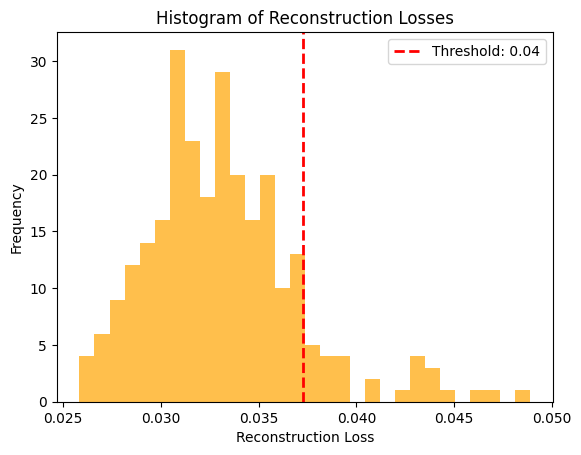

<Figure size 2000x500 with 0 Axes>

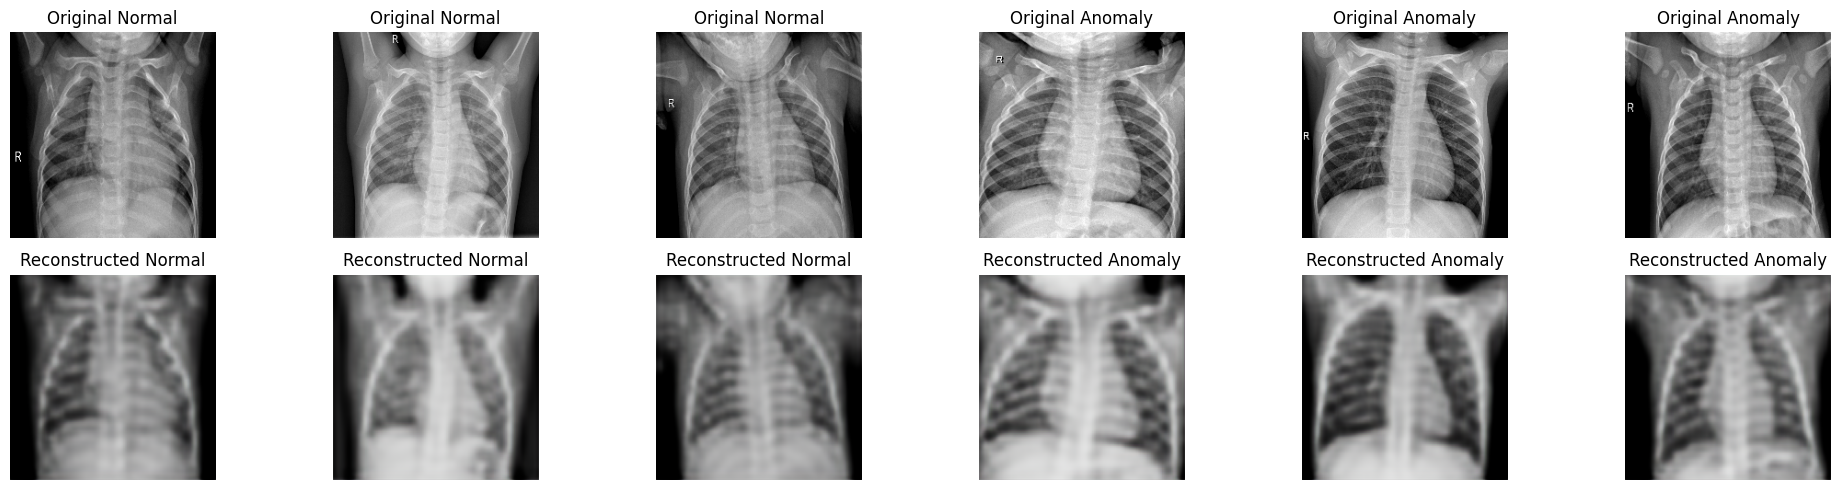

In [ ]:
# ----------------- val loss option two -----------------

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

reconstructed_images_val = autoencoder.predict(X_val)
#val_loss_two = np.mean(np.square(X_val - reconstructed_images_val), axis=(1, 2, 3))
val_loss_two = np.mean(np.abs(X_val - reconstructed_images_val), axis=(1, 2, 3)) # contains a mean value for each image
threshold_two = np.percentile(val_loss_two, 87)  # For example, using the 95th percentile as the threshold

# Print the value of threshold_two
print("Threshold two:", threshold_two)

# Plot histogram of reconstruction losses
plt.hist(val_loss_two, bins=30 , color='orange', alpha=0.7)
plt.xlabel('Reconstruction Loss')
plt.ylabel('Frequency')
plt.title('Histogram of Reconstruction Losses')
plt.axvline(threshold_two, color='red', linestyle='dashed', linewidth=2, label=f'Threshold: {threshold_two:.2f}') # Add threshold line to the histogram
plt.legend()
plt.show()


# Detect anomalies
anomalies_idx_two = np.where(val_loss_two > threshold_two)[0]

# Plot some normal and anomalous images
plt.figure(figsize=(20, 5))  # Adjust the figure size
num_anomalies = len(anomalies_idx_two)
num_plots = min(6, num_anomalies + 3)  # Ensure we plot at most 6 images
indices_to_plot = [1, 3, 5] + anomalies_idx_two.tolist()[:3]  # Indices to plot: 3 normal + 3 anomalies (if available)

# Create subplots
fig, axes = plt.subplots(2, num_plots, figsize=(20, 5))

for i, idx in enumerate(indices_to_plot):
    # Check if index is valid
    if idx < len(X_val):
        # Plot original image
        axes[0, i].imshow(X_val[idx].reshape(224, 224, 3))  # Assuming the input size is 224x224
        if idx in anomalies_idx_two:
            axes[0, i].set_title("Original Anomaly")  # Set title as "Anomaly" for anomalous images
        else:
            axes[0, i].set_title("Original Normal")   # Set title as "Normal" for normal images
        axes[0, i].axis('off')

        # Plot corresponding reconstructed image
        axes[1, i].imshow(reconstructed_images_val[idx].reshape(224, 224, 3))  # Assuming the input size is 224x224
        if idx in anomalies_idx_two:
            axes[1, i].set_title("Reconstructed Anomaly")  # Set title as "Reconstructed Anomaly" for anomalous images
        else:
            axes[1, i].set_title("Reconstructed Normal")   # Set title as "Reconstructed Normal" for normal images
        axes[1, i].axis('off')
    else:
        # If the index is out of range, leave the subplot empty
        axes[0, i].axis('off')
        axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Calculate reconstruction loss for validation images
reconstructed_images_test = autoencoder.predict(X_test)
test_loss = np.mean(np.abs(X_test - reconstructed_images_test), axis=(1, 2, 3))

predicted_labels_test = []
threshold_two_testing = threshold_two -0.01
#threshold_two_testing = threshold_two
# Iterate over each reconstruction loss in test_loss
for loss in test_loss:
    # Check if the loss is greater than the threshold
    if loss < threshold_two_testing:
        # If so, append 'anomaly' to the predicted_labels_test list
        predicted_labels_test.append('anomaly')
    else:
        # Otherwise, append 'normal'
        predicted_labels_test.append('NORMAL')

print("threshold two : ", threshold_two_testing, "\n")

# Print the predicted and true labels for the test set and also loss val for each image
for i, (predicted_label, true_label, test_image_loss) in enumerate(zip(predicted_labels_test, Y_test, test_loss)):
    print(f"Image {i}: Predicted Label - {predicted_label}, True Label - {true_label}, Loss Val - {test_image_loss}")

from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# Map "pneumonia" to "anomaly" in Y_test
Y_test_mapped = np.where(Y_test == "PNEUMONIA", "anomaly", Y_test)

# Combine true and predicted labels
all_labels = np.concatenate([Y_test_mapped, predicted_labels_test])

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit LabelEncoder on combined labels
label_encoder.fit(all_labels)

# Convert string labels to numerical labels
Y_test_encoded = label_encoder.transform(Y_test_mapped)
predicted_labels_test_encoded = label_encoder.transform(predicted_labels_test)

# Generate classification report
report = classification_report(Y_test_encoded, predicted_labels_test_encoded, target_names=label_encoder.classes_)

# Print the classification report
print(report)

20/20 [==============================] - 132s 6s/step
threshold two :  0.027259147316217425 

Image 0: Predicted Label - NORMAL, True Label - NORMAL, Loss Val - 0.030315184965729713
Image 1: Predicted Label - NORMAL, True Label - NORMAL, Loss Val - 0.03422107174992561
Image 2: Predicted Label - NORMAL, True Label - NORMAL, Loss Val - 0.041643161326646805
Image 3: Predicted Label - NORMAL, True Label - NORMAL, Loss Val - 0.03587033972144127
Image 4: Predicted Label - NORMAL, True Label - NORMAL, Loss Val - 0.03687676042318344
Image 5: Predicted Label - NORMAL, True Label - NORMAL, Loss Val - 0.030915575101971626
Image 6: Predicted Label - NORMAL, True Label - NORMAL, Loss Val - 0.04507201537489891
Image 7: Predicted Label - NORMAL, True Label - NORMAL, Loss Val - 0.03600263595581055
Image 8: Predicted Label - NORMAL, True Label - NORMAL, Loss Val - 0.03430674970149994
Image 9: Predicted Label - NORMAL, True Label - NORMAL, Loss Val - 0.0350467674434185
Image 10: Predicted Label - NORMAL